In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import warnings
from typing import Tuple

import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score

sys.path.append("/app")
from visualizations.scripts.drawer import metric_viewer, russia_plots, russia_plots_n
from scripts.processing import read_table_gauge_str

gpd.options.io_engine = "pyogrio"

warnings.simplefilter(action="ignore", category=FutureWarning)

plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']


def get_silhouette_scores(features: np.ndarray) -> Tuple[dict]:
    """Calculate the mean and min silhouette score of a range of possible cluster numbers.

    Parameters
    ----------
    features : np.ndarray
        Array containing the input features.

    Returns
    -------
    mean_scores : dict
        Dictionary containing the mean silhouette scores for each cluster number
    min_scores : dict
        Dictionary containing the min silhouette scores for each cluster number

    """
    mean_scores, min_scores = {}, {}
    min_scores = {}
    for n_clusters in range(3, 20, 1):
        clusterer = KMeans(n_clusters=n_clusters, random_state=0, init="k-means++")
        cluster_labels = clusterer.fit_predict(features)
        silhouette_scores = silhouette_samples(
            X=features, labels=cluster_labels, metric="euclidean"
        )
        mean_scores[n_clusters] = np.mean(silhouette_scores)
        min_scores[n_clusters] = np.min(silhouette_scores)

    return mean_scores, min_scores


def get_high_silhoute(input_df: pd.DataFrame):
    clusters_range = range(2, 21)
    silhoute_result = dict()
    # data = pca95(input_df)
    data = input_df

    for i in clusters_range:
        km = KMeans(n_clusters=i, random_state=42)
        cluster_labels = km.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        silhoute_result[i] = silhouette_avg

    fig, ax = plt.subplots(figsize=(15, 8))

    x = list(silhoute_result.keys())
    y = list(silhoute_result.values())

    ax.plot(x, y, "-")
    line_x = x[np.argmax(y)]
    ax.axvline(x=line_x, color="r")

    ax.set_xlabel("Количество кластеров, шт.", fontsize=14)
    ax.set_ylabel("Величина силуэта", fontsize=14)
    ax.set_title(
        f"Максимальная величина силуэта найдена для {line_x} кластеров", fontsize=14
    )
    ax.xaxis.set_major_locator(ticker.FixedLocator(locs=[i for i in range(1, 21)]))
    ax.set_xticklabels([f"{i}" for i in range(1, 21)])

    plt.setp(ax.get_yticklabels(), fontsize=10)
    plt.setp(ax.get_xticklabels(), fontsize=10)
    ax.grid(False)
    plt.show()

    return fig

### Read necessary geometry

In [3]:
gauges_file = gpd.read_file("../geo_data/geometry/russia_gauges.gpkg")
gauges_file["gauge_id"] = gauges_file["gauge_id"].astype(str)
gauges_file = gauges_file.set_index("gauge_id")
ws_file = gpd.read_file("../geo_data/geometry/russia_ws.gpkg")
ws_file = ws_file.set_index("gauge_id")
ws_file = ws_file[ws_file["new_area"] <= 50000]


def lim_definer(area: float):
    lim_1, lim_2, lim_3, lim_4 = 100, 2000, 10000, 50000

    if area < lim_1:
        return "а) < 100 $км^2$"
    elif (area >= lim_1) & (area <= lim_2):
        return "б) 100 $км^2$ - 2 000 $км^2$"
    elif (area > lim_2) & (area <= lim_3):
        return "в) 2 000 $км^2$ - 10 000 $км^2$"
    elif (area > lim_3) & (area <= lim_4):
        return "г) 10 000 $км^2$ - 50 000 $км^2$"
    else:
        return "> 50 000 $км^2$"


ws_file["size"] = ws_file.loc[:, "new_area"].apply(lambda x: lim_definer(x))
ws_file["size"] = pd.Categorical(
    ws_file["size"],
    [
        "а) < 100 $км^2$",
        "б) 100 $км^2$ - 2 000 $км^2$",
        "в) 2 000 $км^2$ - 10 000 $км^2$",
        "г) 10 000 $км^2$ - 50 000 $км^2$",
    ],
)

basemap_data = gpd.read_file("../geo_data/geometry/basemap_2023.gpkg")

basin_districts = gpd.read_file("../geo_data/geometry/basin_districts.gpkg")
basin_districts = basin_districts.reset_index(drop=True)
basin_districts = basin_districts.drop([26, 27])
basin_districts = basin_districts.rename(columns={"BAS_OKRUG": "name1"})

### Use only gauges from LSTM model

In [4]:
hbv_table = pd.read_csv(
    "./tables/HBV_res_mle_NSE.csv",
    index_col="gauge_id",
    dtype={"gauge_id": str},
)
gr4j_table = pd.read_csv(
    "./tables/GR4J_res_mle_NSE.csv",
    index_col="gauge_id",
    dtype={"gauge_id": str},
)
rfr_table = pd.read_csv(
    "./tables/res_rfr_cv.csv",
    index_col="gauge_id",
    dtype={"gauge_id": str},
)
lstm_table = pd.read_csv(
    "./tables/cudalstm_q_mm_day_mswep_res.csv",
    index_col="gauge_id",
    dtype={"gauge_id": str},
)

common_index = (
    hbv_table.index.intersection(gr4j_table.index)
    .intersection(rfr_table.index)
    .intersection(lstm_table.index)
    .intersection(ws_file.index)
)


ws_file = ws_file.loc[common_index, :]
gauges_file = gauges_file.loc[common_index, :]
gauges_file['size'] = np.NaN
gauges_file = gauges_file.combine_first(ws_file)
gauges_file = gauges_file.set_crs(epsg=4326)

### Area plot distribution

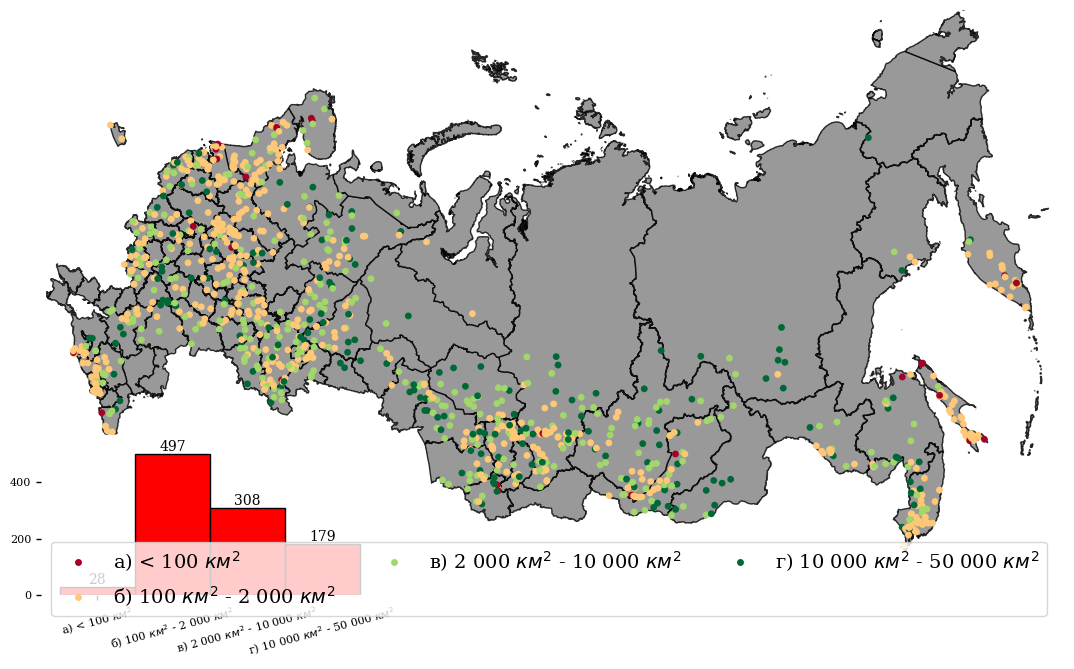

In [5]:
gauges_fig = russia_plots(
    gdf_to_plot=gauges_file,
    basemap_data=basemap_data,
    distinction_col="size",
    # cmap_name='tab20',
    #   metric_col='Кластер',
    # list_of_limits=list(range(1, 5)),
    figsize=(15, 8),
    just_points=True,
    with_histogram=True,
)

### Geo-clusters

In [6]:
static_attrs = pd.read_csv("../geo_data/static_data.csv")
static_attrs["gauge_id"] = static_attrs["gauge_id"].astype(str)
static_attrs = static_attrs.set_index("gauge_id")
# adjust indexes in accordance to size of data
static_attrs = static_attrs.loc[common_index, :]

static_parameters = [
    "for_pc_sse",
    "crp_pc_sse",
    "inu_pc_ult",
    "ire_pc_sse",
    "lka_pc_use",
    "prm_pc_sse",
    "pst_pc_sse",
    "cly_pc_sav",
    "slt_pc_sav",
    "snd_pc_sav",
    "kar_pc_sse",
    "urb_pc_sse",
    "gwt_cm_sav",
    "lkv_mc_usu",
    "rev_mc_usu",
    "ws_area",
    "ele_mt_sav",
]
# static_attrs = static_attrs[static_parameters]
static_norm = (static_attrs - static_attrs.mean()) / static_attrs.std()
static_norm = static_norm.dropna(axis=1)
raw_features = static_norm.values

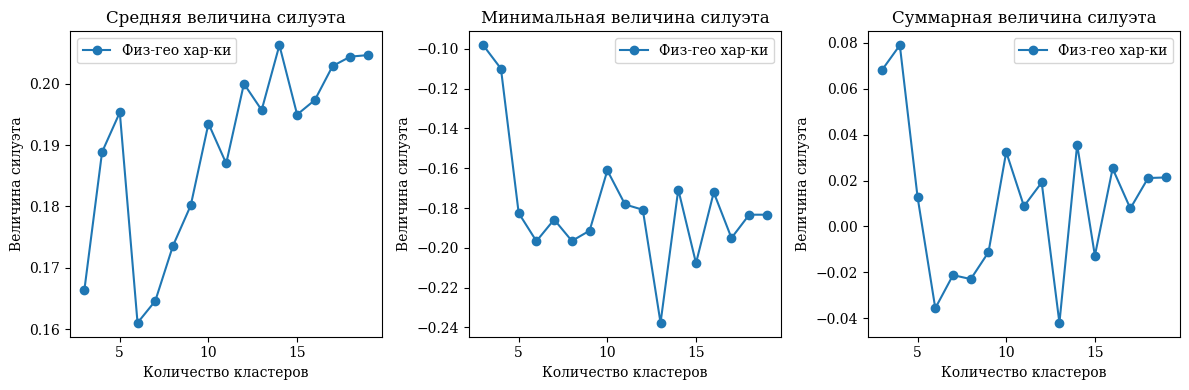

In [7]:
# static_cluster_data = deepcopy(static_attrs)
# static_cluster_data = static_cluster_data.dropna()

# static_cluster_data.loc[:, :] = StandardScaler().fit_transform(
#     static_cluster_data.values
# )

# pca_vals = pca95(static_cluster_data)
# static_pca = pd.DataFrame(
#     columns=[f"pc_{i}" for i in range(pca_vals.shape[1])],
#     index=static_cluster_data.index,
# )
# static_pca.index.name = "gauge_id"
# static_pca.loc[:, :] = pca_vals
raw_scores_means, raw_scores_mins = get_silhouette_scores(raw_features)


def dict_subtract(dict1, dict2):
    """Subtract the values of two dictionaries.

    Parameters
    ----------
    dict1 : dict
        The first dictionary.
    dict2 : dict
        The second dictionary.

    Returns
    -------
    subtract_dict : dict
        A dictionary containing the subtracted values between dict1 and dict2.

    """
    subtract_dict = {}
    for key in dict1.keys():
        if key in dict2.keys():
            subtract_dict[key] = dict1[key] + dict2[key]
        else:
            subtract_dict[key] = dict1[key]
    for key in dict2.keys():
        if key not in dict1.keys():
            subtract_dict[key] = dict2[key]
    return subtract_dict


raw_score_max = dict_subtract(raw_scores_means, raw_scores_mins)

fig, ax = plt.subplots(ncols=3, figsize=(12, 4))
ax[0].plot(
    list(raw_scores_means.keys()),
    list(raw_scores_means.values()),
    marker="o",
    markevery=1,
    label="Физ-гео хар-ки",
)
ax[0].set_xlabel("Количество кластеров")
ax[0].set_ylabel("Величина силуэта")
ax[0].set_title("Средняя величина силуэта")
ax[0].legend()

ax[1].plot(
    list(raw_scores_mins.keys()),
    list(raw_scores_mins.values()),
    marker="o",
    markevery=1,
    label="Физ-гео хар-ки",
)
ax[1].set_xlabel("Количество кластеров")
ax[1].set_ylabel("Величина силуэта")
ax[1].set_title("Минимальная величина силуэта")
ax[1].legend()

ax[2].plot(
    list(raw_score_max.keys()),
    list(raw_score_max.values()),
    marker="o",
    markevery=1,
    label="Физ-гео хар-ки",
)
ax[2].set_xlabel("Количество кластеров")
ax[2].set_ylabel("Величина силуэта")
ax[2].set_title("Суммарная величина силуэта")
ax[2].legend()

plt.tight_layout()

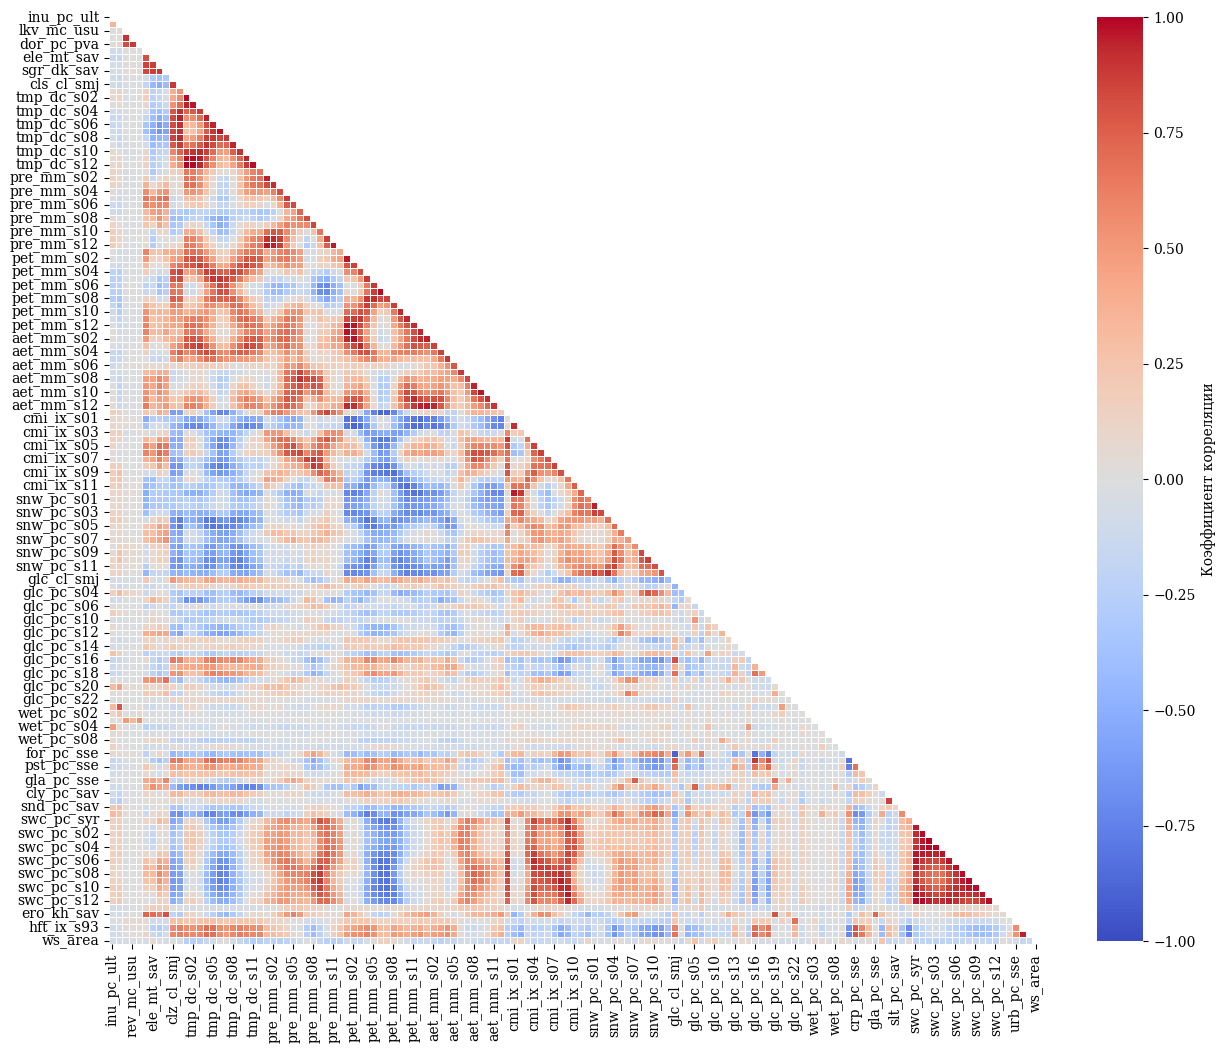

In [8]:
correlation_matrix = static_norm.corr()
correlation_matrix = correlation_matrix.where(
    np.tril(np.ones(correlation_matrix.shape), k=-1).astype(bool)
)
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(
    correlation_matrix,
    cmap="coolwarm",
    ax=ax,
    robust=True,
    vmax=1.0,
    vmin=-1.0,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8,
              "label": "Коэффициент корреляции"},
);

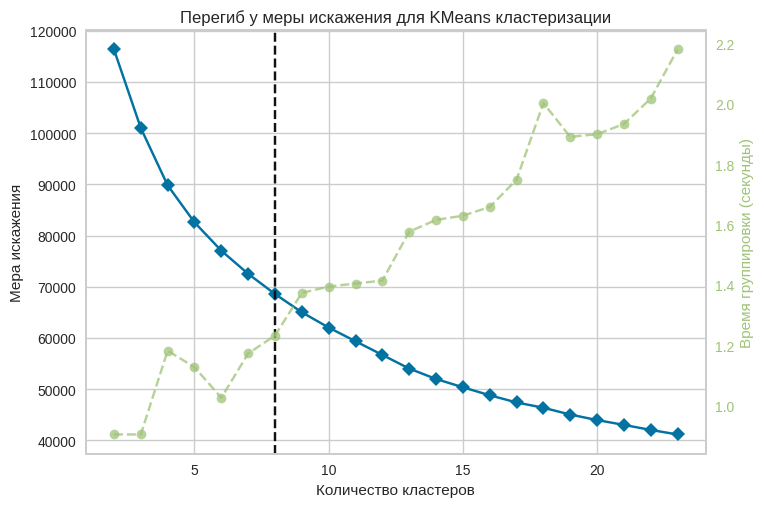

In [11]:
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans(random_state=42, init="k-means++", n_init=420)
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,24), timings=True)
visualizer.fit(raw_features)        # Fit data to visualizer
visualizer.show();

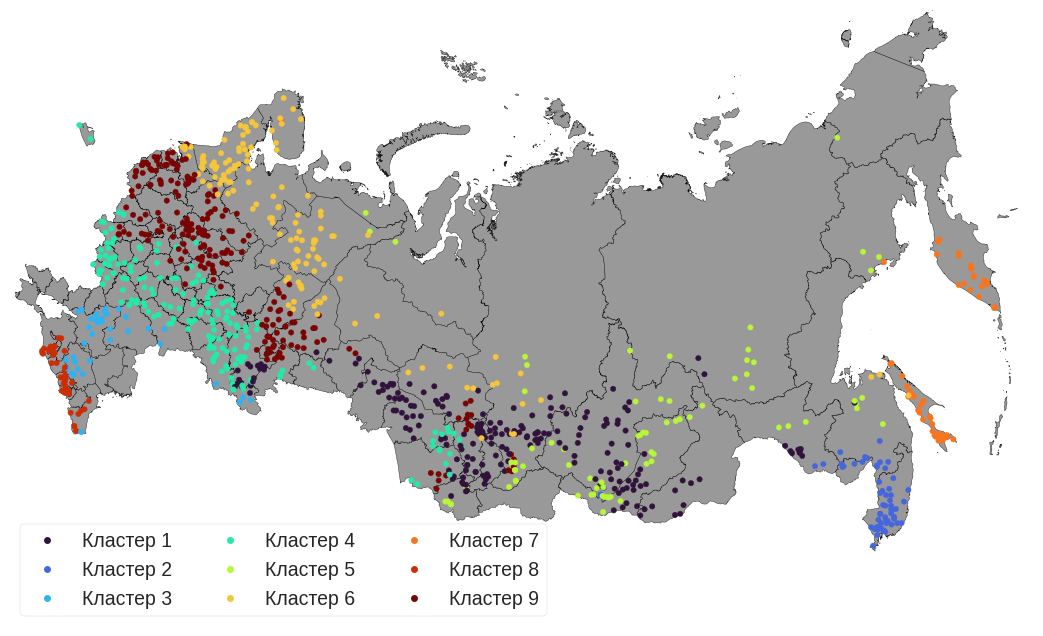

In [10]:
number_of_clusters = 9

# cluster_alg = SpectralClustering(
#     n_clusters=number_of_clusters,
#     random_state=42,
#     # affinity="rbf",
#     assign_labels="kmeans",
#     n_neighbors=static_norm.__len__() // number_of_clusters,
# )
cluster_alg = KMeans(
    n_clusters=number_of_clusters, random_state=42, init="k-means++", n_init=600
)
# cluster_alg = AgglomerativeClustering(
#     n_clusters=number_of_clusters, linkage="ward", compute_full_tree=True
# )

yhat_AC = cluster_alg.fit_predict(raw_features)
static_norm["ResClust"] = [i + 1 for i in yhat_AC]

gauges_file["ResClust"] = np.NaN
static_attrs["ResClust"] = np.NaN

gauges_file = gauges_file.combine_first(static_norm).dropna()
static_attrs = static_attrs.combine_first(static_norm).dropna()
gauges_file["Кластер"] = [f"Кластер {int(i)}" for i in gauges_file["ResClust"]]

gauges_fig = russia_plots(
    gdf_to_plot=gauges_file,
    basemap_data=basemap_data,
    distinction_col="Кластер",
    cmap_name="turbo",
    #   metric_col='Кластер',
    list_of_limits=list(range(1, 5)),
    figsize=(15, 8),
    just_points=True)

### Hydro-clusters